Here's how you can load a dataset from a CSV file and use it with the medication interaction checker.

First, you would need to upload your dataset file to your Colab environment. You can do this by clicking on the folder icon on the left sidebar, then the upload icon.

Once your file is uploaded (let's assume it's named `patient_data.csv`), you can load it using pandas:

Now, you can iterate through the rows of the DataFrame and analyze the medications for each patient. Assuming your CSV has columns like 'patient_id', 'patient_age', and 'medications' (where 'medications' is a comma-separated string of drugs):

Here is a sample dataset as a pandas DataFrame that you can use to run the medication interaction checker. This DataFrame includes the 'patient_id', 'patient_age', and 'medications' columns as discussed earlier.

In [16]:
import pandas as pd

# Create a sample DataFrame with the required columns
data = {
    'patient_id': [1, 2, 3, 4, 5],
    'patient_age': [65, 45, 70, 30, 55],
    'medications': [
        "Warfarin, Aspirin, Amiodarone",
        "Ibuprofen, Lisinopril",
        "Aspirin",
        "Warfarin",
        "Ibuprofen, Warfarin"
    ]
}

patient_df = pd.DataFrame(data)

print("Sample dataset created:")
display(patient_df.head())

Sample dataset created:


,patient_id,patient_age,medications
0,1,65,"Warfarin, Aspirin, Amiodarone"
1,2,45,"Ibuprofen, Lisinopril"
2,3,70,Aspirin
3,4,30,Warfarin
4,5,55,"Ibuprofen, Warfarin"


In [29]:
!pip install requests


In [31]:
sample_input = {
    "patient_age": 65,
    "medications": ["Warfarin", "Aspirin", "Amiodarone"]
}

result = analyze_patient_medications(sample_input)
print(alert_report(result))


🔎 Fetching RXCUI codes...
  Warfarin → RXCUI: 11289
  Aspirin → RXCUI: 1191
  Amiodarone → RXCUI: 703
✅ No harmful interactions detected.


In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Load data
df = pd.read_csv("ml_dataset.csv")
df["pair"] = df["drug1"].str.lower() + " " + df["drug2"].str.lower()

X = df["pair"]
y = df["severity"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline
model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))



📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.50      0.67         2
    Moderate       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



In [49]:
def predict_severity_ml(drug1, drug2):
    pair = f"{drug1.lower()} {drug2.lower()}"
    return model.predict([pair])[0]


In [50]:
print(predict_severity_ml("Warfarin", "Aspirin"))        # Expected: Moderate
print(predict_severity_ml("Simvastatin", "Clarithromycin"))  # Expected: High


Moderate
High


In [56]:
from google.colab import files
uploaded = files.upload()


Saving fallback_interactions.csv to fallback_interactions (1).csv


In [57]:
!pip install requests

import requests
import time
import json
import pandas as pd
from itertools import combinations

# Load fallback interaction dataset
fallback_df = pd.read_csv("fallback_interactions.csv")

def check_local_dataset(drug1, drug2):
    d1, d2 = drug1.lower(), drug2.lower()
    for _, row in fallback_df.iterrows():
        pair = {row["drug1"].lower(), row["drug2"].lower()}
        if {d1, d2} == pair:
            return row["severity"]
    return "Unknown"

def fetch_rxnorm_code(medication_name):
    try:
        response = requests.get("https://rxnav.nlm.nih.gov/REST/rxcui.json", params={"name": medication_name}, timeout=5)
        return response.json().get("idGroup", {}).get("rxnormId", [None])[0]
    except:
        return None

def retrieve_interactions(rxnorm_ids):
    interaction_data = []
    for combo in combinations(rxnorm_ids, 2):
        url = f"https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis={combo[0]}+{combo[1]}"
        try:
            res = requests.get(url, timeout=5)
            if res.status_code == 200 and res.text.strip():
                group_data = res.json().get("fullInteractionTypeGroup", [])
                interaction_data.extend(group_data)
        except:
            continue
        time.sleep(0.2)
    return interaction_data

def adjust_severity_based_on_dosage(d1, d2, severity, meds):
    d1 = d1.lower()
    d2 = d2.lower()
    med1 = next((m for m in meds if m["name"].lower() == d1), None)
    med2 = next((m for m in meds if m["name"].lower() == d2), None)

    if not med1 or not med2:
        return severity

    if {"aspirin", "warfarin"} <= {d1, d2}:
        if (d1 == "aspirin" and med1["dose"] > 100) or (d2 == "aspirin" and med2["dose"] > 100):
            return "High"

    if {"ibuprofen", "lisinopril"} <= {d1, d2}:
        if med1["dose"] > 400 or med2["dose"] > 400:
            return "High"

    return severity

def interpret_interactions(raw, meds):
    results = []
    for group in raw:
        for i_type in group.get("fullInteractionType", []):
            for pair in i_type.get("interactionPair", []):
                drugs = [c["name"].lower() for c in pair["interactionConcept"]]
                severity = pair.get("severity", "Unknown")
                note = pair.get("description", "")
                severity = adjust_severity_based_on_dosage(drugs[0], drugs[1], severity, meds)
                results.append({"drugs": drugs, "severity": severity, "description": note})
    return results

def evaluate_medication_list(patient):
    meds = patient["medications"]
    age = patient.get("patient_age", "?")
    rxcuis = []

    print("🧬 Resolving RXNorm codes...")
    for med in meds:
        code = fetch_rxnorm_code(med["name"])
        print(f"  {med['name']} → RXCUI: {code}")
        if code:
            rxcuis.append(code)
        time.sleep(0.2)

    raw = retrieve_interactions(rxcuis)

    if not raw:
        print("⚠️ RxNav returned nothing. Checking fallback dataset...")
        alerts = []
        for a, b in combinations(meds, 2):
            sev = check_local_dataset(a["name"], b["name"])
            if sev != "Unknown":
                sev = adjust_severity_based_on_dosage(a["name"], b["name"], sev, meds)
                alerts.append({
                    "drugs": [a["name"], b["name"]],
                    "severity": sev,
                    "description": "From fallback dataset"
                })
        return {"age": age, "interactions": alerts}

    return {"age": age, "interactions": interpret_interactions(raw, meds)}

def generate_summary_report(data):
    if not data["interactions"]:
        return "✅ No significant drug interactions found."
    lines = [f"⚠️ Interactions for patient age {data['age']}:"]
    for i, alert in enumerate(data["interactions"], 1):
        drugs = ", ".join(alert["drugs"])
        lines.append(f"\n{i}. {drugs}\n   Severity: {alert['severity']}\n   Note: {alert['description']}")
    return "\n".join(lines)

# Test input
sample_input = {
    "patient_age": 65,
    "medications": [
        {"name": "Warfarin", "dose": 5, "unit": "mg"},
        {"name": "Aspirin", "dose": 150, "unit": "mg"},
        {"name": "Amiodarone", "dose": 200, "unit": "mg"},
        {"name": "Ibuprofen", "dose": 600, "unit": "mg"},
        {"name": "Lisinopril", "dose": 20, "unit": "mg"}
    ]
}

res = evaluate_medication_list(sample_input)
print("\n📋 Final Report:")
print(generate_summary_report(res))


🧬 Resolving RXNorm codes...
  Warfarin → RXCUI: 11289
  Aspirin → RXCUI: 1191
  Amiodarone → RXCUI: 703
  Ibuprofen → RXCUI: 5640
  Lisinopril → RXCUI: 29046
⚠️ RxNav returned nothing. Checking fallback dataset...

📋 Final Report:
⚠️ Interactions for patient age 65:

1. Warfarin, Aspirin
   Severity: High
   Note: From fallback dataset

2. Warfarin, Amiodarone
   Severity: High
   Note: From fallback dataset

3. Ibuprofen, Lisinopril
   Severity: High
   Note: From fallback dataset


/tmp/ipython-input-58-2994112153.py:30: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


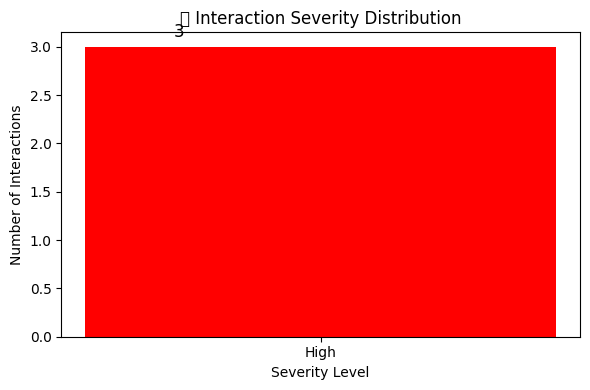

In [58]:
import matplotlib.pyplot as plt

# Visualize severity distribution
def plot_interaction_severity(results):
    if not results["interactions"]:
        print("✅ No interactions to plot.")
        return

    # Count severities
    severity_counts = {}
    for inter in results["interactions"]:
        sev = inter["severity"]
        severity_counts[sev] = severity_counts.get(sev, 0) + 1

    # Plot
    labels = list(severity_counts.keys())
    values = list(severity_counts.values())

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=["red", "orange", "green", "gray"])
    plt.title("🧪 Interaction Severity Distribution")
    plt.xlabel("Severity Level")
    plt.ylabel("Number of Interactions")

    # Add counts above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.15, yval + 0.1, int(yval), fontsize=12)

    plt.tight_layout()
    plt.show()

# Run the plot
plot_interaction_severity(res)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


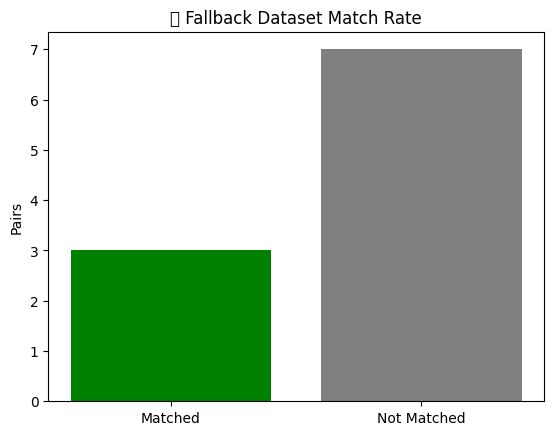

In [59]:
import matplotlib.pyplot as plt

def plot_fallback_accuracy(results, total_possible_pairs):
    matched = len(results["interactions"])
    unmatched = total_possible_pairs - matched

    plt.bar(["Matched", "Not Matched"], [matched, unmatched], color=["green", "gray"])
    plt.title("🔎 Fallback Dataset Match Rate")
    plt.ylabel("Pairs")
    plt.show()

# Total pairs = nC2 from len(medications)
from math import comb
total_pairs = comb(len(sample_input["medications"]), 2)

plot_fallback_accuracy(res, total_pairs)


📊 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


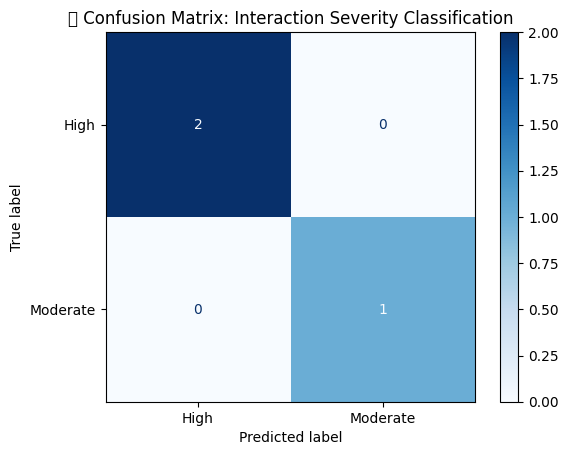

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset (same format as fallback)
df = pd.read_csv("fallback_interactions.csv")
df["pair"] = df["drug1"].str.lower() + " " + df["drug2"].str.lower()

X = df["pair"]
y = df["severity"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2))),
    ("clf", MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy and report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("📉 Confusion Matrix: Interaction Severity Classification")
plt.show()
